Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


### Function to generate a training batch for the skip-gram model.

In [ ]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch  = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span   = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target           = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j]     = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

#### Train a skip-gram model.

In [ ]:
batch_size     = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window    = 1 # How many words to consider left and right.
num_skips      = 2 # How many times to reuse an input to generate a label.


# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size     = 16 # Random set of words to evaluate similarity on.
valid_window   = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled    = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels  = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings      = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases  = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  loss  = tf.reduce_mean(
              tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                                         biases=softmax_biases, 
                                         inputs=embed,
                                         labels=train_labels, 
                                         num_sampled=num_sampled, 
                                         num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm                  = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings      = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity            = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

In [ ]:
num_points       = 400
tsne             = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [ ]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
    
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

### Function to generate a training batch for the cbow model:

In [5]:
data_index = 0

def generate_cbow_batch(batch_size, bag_window):
    global data_index
    span   = bag_window + 1 + bag_window
    batch  = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32) # [w1 w2   w3 w4]
    labels = np.ndarray(shape=(batch_size, 1),        dtype=np.int32) # [     w3      ] 
    
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data) # initial fill-up
    
    for i in range(batch_size):
       
        buffer_list  = list(buffer)
        labels[i]    = buffer_list.pop(bag_window) # label = popped central element
        batch[i]     = buffer_list                 # batch = context elements 
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    return batch, labels

In [6]:
print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    bsize = 3
    
    batch, labels = generate_cbow_batch(batch_size=bsize, bag_window=bag_window)
     
    context = [[reverse_dictionary[w] for w in bi] for bi in batch]
    center  = [reverse_dictionary[li] for li in labels.reshape(bsize)]
    
    print('\nfor window size %d:' % (bag_window))  
    
    for con,cen in zip(context,center):
        print('batch:', con)  
        print('label:', cen)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

for window size 1:
batch: ['anarchism', 'as']
label: originated
batch: ['originated', 'a']
label: as
batch: ['as', 'term']
label: a

for window size 2:
batch: ['anarchism', 'originated', 'a', 'term']
label: as
batch: ['originated', 'as', 'term', 'of']
label: a
batch: ['as', 'a', 'of', 'abuse']
label: term


### CBOW

In [7]:
batch_size     = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_window     =   2 # How many words to consider left and right.
num_skips      =   2 # How many times to reuse an input to generate a label.

In [8]:
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size     =  16 # Random set of words to evaluate similarity on.
valid_window   = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled    =  64 # Number of negative examples to sample.

In [9]:
cbow_graph = tf.Graph()

with cbow_graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels  = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    eshape          = [vocabulary_size, embedding_size]
    embeddings      = tf.Variable(tf.random_uniform(eshape, -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal(eshape, stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases  = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset) # [w1 w2 w4 w5 ] in 4 x Dim
    avg   = tf.reduce_sum(embed, 1)                           # [w_avg]        in 1 x Dim
    loss  = tf.reduce_mean(
              tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                                         biases=softmax_biases, 
                                         inputs=avg,
                                         labels=train_labels, 
                                         num_sampled=num_sampled, 
                                         num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  

    norm                  = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings      = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity            = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

with tf.Session(graph=cbow_graph) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_cbow_batch(batch_size, bag_window)
        # print(batch_data.shape)
        # print(batch_labels.shape)

        feed_dict                = {train_dataset:batch_data, train_labels:batch_labels}

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000 # estimate of the loss over the last 2000 batches.
            print('\nAverage loss at step %d: %f' % (step, average_loss))
            average_loss = 0

        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k      = 8 # number of nearest neighbors
                nearest    = (-sim[i, :]).argsort()[1:top_k+1]
                log        = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)

    final_embeddings = normalized_embeddings.eval()

Initialized

Average loss at step 0: 8.495901
Nearest to known: personages, gamal, dabbled, cleric, appreciated, paralleled, distributes, devolved,
Nearest to while: protectorates, interactive, phrasing, amyotrophic, factions, millionaire, briefs, christof,
Nearest to may: iceni, interpolations, sombart, negroponte, preserves, kisses, thinks, recoverable,
Nearest to use: sacr, turbocharged, berliners, thessalonians, shortens, vince, cartesian, umayyad,
Nearest to up: bowhunting, peshitta, crystalline, gordie, impact, bow, hoboken, scud,
Nearest to d: garrisoned, mounting, coy, neustria, equal, diameter, fm, rai,
Nearest to s: buddhist, juris, myriad, collegium, clipper, ezek, quarto, scruggs,
Nearest to many: already, materiality, lineage, bombard, sava, surprising, possessed, centrale,
Nearest to are: alcal, cante, templar, linked, encrusted, cursive, grasped, fulgencio,
Nearest to has: sideline, corey, nostrand, appears, roughly, solemnity, hypnotherapy, tait,
Nearest to between: gla


Average loss at step 52000: 3.096496

Average loss at step 54000: 3.093001

Average loss at step 56000: 2.919727

Average loss at step 58000: 3.024057

Average loss at step 60000: 3.048431
Nearest to known: referred, used, seen, described, regarded, defined, cited, classified,
Nearest to while: although, and, though, when, however, if, or, including,
Nearest to may: can, should, must, could, will, might, would, cannot,
Nearest to use: form, allow, refers, reduce, remove, devanagari, glock, comrades,
Nearest to up: off, out, down, back, forth, ict, molybdenum, pequod,
Nearest to d: b, p, isaurian, prelates, photoshop, koruna, mons, encamped,
Nearest to s: his, her, whose, crawford, ore, tablet, their, oda,
Nearest to many: some, several, various, all, numerous, certain, both, most,
Nearest to are: were, is, include, was, have, including, exist, contain,
Nearest to has: had, have, includes, having, is, makes, allows, involves,
Nearest to between: with, among, across, hedwig, through, re

In [11]:
num_points       = 400
tsne             = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

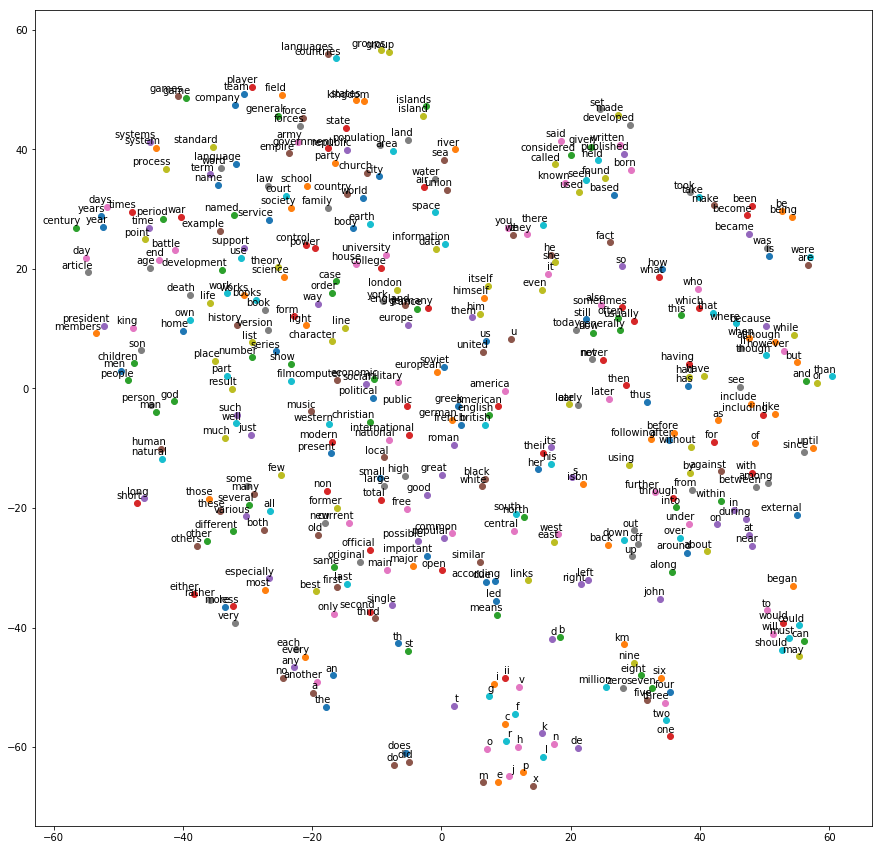

In [12]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches

    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points',ha='right', va='bottom')
    
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)